In [1]:
from create_percent_diff_summary import invert_dotson_fcn, invert_pig_fcn, invert_thwaites_fcn, eval_models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar
import os
import sys
import copy
import pickle
import pandas as pd

2024-10-28 19:11:48.022997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 19:11:48.027002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 19:11:48.038302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730142708.058184 1200421 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730142708.063880 1200421 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 19:11:48.086176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Get the evaluated objects and results for Dotson, PIG, and Thwaites
inv_dotson, theta_dotson, C_dotson = invert_dotson_fcn()

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport
Reading velocity from measures database
C0 is constant: 0.01
Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     1.212709e+08   6.286605e+03                  2.025274e+04   
  1     4.245683e+07   2.185766e+03   2.025274e+04   5.063186e+04   3         2         0         1         3         
  2     7.537494e+06   3.973020e+02   5.063186e+04   5.063186e+04   4         3         0         2         2         
  3     1.338595e+06   5.088845e+01   5.063186e+04   5.063186e+04   5         4         0         3         2         
  4     3.167263e+05   1.325799e+01   5.063186e+04   5.063186e+04   6         5         0      

In [3]:
inv_pig, theta_pig, C_pig = invert_pig_fcn()

Reading outline from icepack database
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport
Reading velocity from measures database
C0 is constant: 0.01
Using loss function with sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     9.539353e+06   7.593147e+02                  1.586947e+04   
  1     3.486379e+06   2.159048e+02   1.586947e+04   3.967367e+04   3         2         0         3         3         
  2     1.037151e+06   6.952250e+01   3.967367e+04   9.918418e+04   4         3         0         3         2         
  3     1.139235e+05   8.840226e+00   9.918418e+04   9.918418e+04   5         4         0         3         2         
  4     1.139235e+05   8.840226e+00   9.918418e+04   6.199011e+03   6         4   

In [4]:
inv_thwaites, theta_thwaites, C_thwaites = invert_thwaites_fcn()

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport
Reading velocity from measures database
C0 is constant: 0.01
Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.144299e+08   1.041549e+04                  2.182136e+04   
  1     7.365918e+07   3.607487e+03   2.182136e+04   5.455339e+04   3         2         0         1         3         
  2     1.276159e+07   8.687447e+02   5.455339e+04   1.363835e+05   4         3         0         3         2         
  3     1.276159e+07   8.687447e+02   1.363835e+05   8.523967e+03   5         3         2         3         2         
  4     7.676839e+06   4.417138e+02   8.523967e+03   2.130992e+04   6         4         0      

In [5]:
select_dataset = 5

In [10]:
%%capture
temp_objects_dotson, summary_list_dotson, columns_list_dotson, u_optimized_list_dotson, loss_function_list_dotson = eval_models(select_dataset, inv_dotson)

In [11]:
%%capture
temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)


Error: error code 56
[0] SNESSolve() at /home/firedrake/petsc/src/snes/interface/snes.c:4666
[0] SNESSolve_KSPONLY() at /home/firedrake/petsc/src/snes/impls/ksponly/ksponly.c:48
[0] KSPSolve() at /home/firedrake/petsc/src/ksp/ksp/interface/itfunc.c:1070
[0] KSPSolve_Private() at /home/firedrake/petsc/src/ksp/ksp/interface/itfunc.c:868
[0] PCPreSolve() at /home/firedrake/petsc/src/ksp/pc/interface/precon.c:1523
[0] No support for this operation for this object type
[0] Cannot embed PCPreSolve() more than twice

In [12]:
%%capture
temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

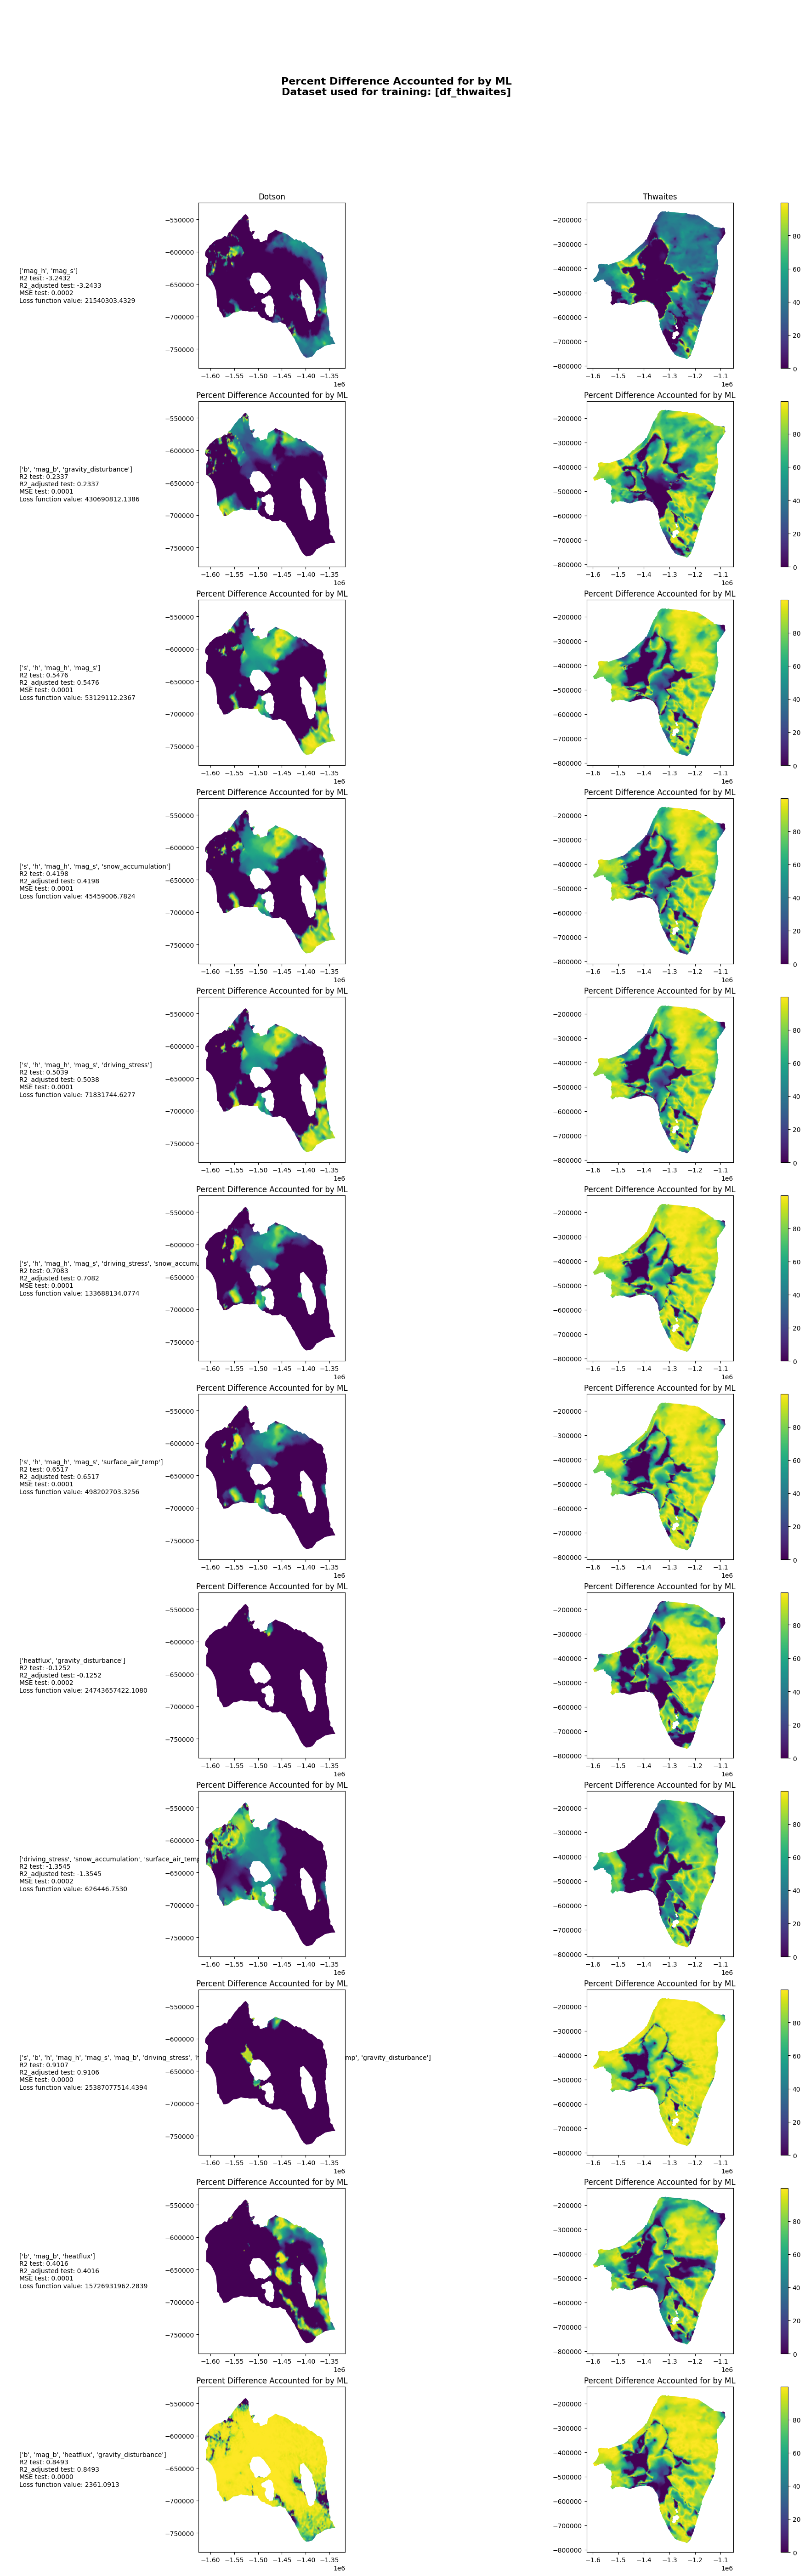

In [14]:
# Determine the dataset used based on select_dataset
if select_dataset == 0:
    dataset_used = "[df_dotson, df_dotson, df_thwaites]"
elif select_dataset == 1:
    dataset_used = "[df_pig, df_pig, df_thwaites]"
elif select_dataset == 2:
    dataset_used = "[df_dotson, df_pig]"
elif select_dataset == 3:
    dataset_used = "[df_dotson]"
elif select_dataset == 4:
    dataset_used = "[df_pig]"
elif select_dataset == 5:
    dataset_used = "[df_thwaites]"

# Since the lists have an equal number of objects, determine the number of rows
n_rows = len(temp_objects_dotson)

# Increase figure size to make the rows larger
fig = plt.figure(figsize=(22, 6 * n_rows))

# Create a gridspec layout with an extra row for the title
# Reduce hspace to decrease vertical gaps between rows
gs = gridspec.GridSpec(n_rows + 1, 5, width_ratios=[4, 4, 4, 4, 0.2], wspace=0.4, hspace=0.2)

# Add a new axes for the title with the dynamic dataset info
ax_title = fig.add_subplot(gs[0, :])
title_text = f"Percent Difference Accounted for by ML\nDataset used for training: {dataset_used}"
ax_title.text(0.5, 0.5, title_text, fontsize=16, weight='bold', ha='center', va='center')
ax_title.axis('off')  # Turn off the axis for the title

# Loop over the objects and plot in the corresponding grid positions
for row in range(n_rows):
    # Summary column (column 0)
    ax_summary = fig.add_subplot(gs[row + 1, 0])
    summary_text = (
        f"{columns_list_dotson[row]}\n"
        f"R2 test: {summary_list_dotson[row]['r2_mean']:.4f}\n"
        f"R2_adjusted test: {summary_list_dotson[row]['r2_adjusted_mean']:.4f}\n"
        f"MSE test: {summary_list_dotson[row]['mse_mean']:.4f}\n"
        f"Loss function value: {loss_function_list_dotson[row]:.4f}"
    )
    ax_summary.text(0.1, 0.5, summary_text, fontsize=10, va="center", ha="left")
    ax_summary.axis('off')  # Turn off the axis for the text column
    
    # Dotson column (column 1)
    ax_dotson = fig.add_subplot(gs[row + 1, 1])
    _, ax_dotson = temp_objects_dotson[row].plot_percent_accounted(vmin=0, axes=ax_dotson)
    if row == 0:
        ax_dotson.set_title("Dotson")
    
    # # PIG column (column 2)
    # ax_pig = fig.add_subplot(gs[row + 1, 2])
    # _, ax_pig = temp_objects_pig[row].plot_percent_accounted(vmin=0, axes=ax_pig)
    # if row == 0:
    #     ax_pig.set_title("PIG")
    
    # Thwaites column (column 3)
    ax_thwaites = fig.add_subplot(gs[row + 1, 3])
    _, ax_thwaites = temp_objects_thwaites[row].plot_percent_accounted(vmin=0, axes=ax_thwaites)
    if row == 0:
        ax_thwaites.set_title("Thwaites")

    # Create a color bar at the end of the row (column 4)
    cax = fig.add_subplot(gs[row + 1, 4])
    fig.colorbar(ax_dotson.collections[0], cax=cax)

# Show the final figure
plt.show()
